In [1]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99%|████████████████████████████████████████▋| 670M/675M [00:04<00:00, 143MB/s]
100%|█████████████████████████████████████████| 675M/675M [00:04<00:00, 164MB/s]


In [2]:
! unzip -q cell-images-for-detecting-malaria.zip -d /kaggle/working && echo "Unzipping completed successfully."

Unzipping completed successfully.


In [3]:
import shutil
import os

def delete_folder(parent_folder, folder_to_delete):
    folder_path = os.path.join(parent_folder, folder_to_delete)
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_to_delete}' deleted successfully from '{parent_folder}'.")
    else:
        print(f"Folder '{folder_to_delete}' does not exist in '{parent_folder}'.")

parent_folder = "/kaggle/working/cell_images"  
folder_to_delete = "/kaggle/working/cell_images/cell_images" 
delete_folder(parent_folder, folder_to_delete)

Folder '/kaggle/working/cell_images/cell_images' deleted successfully from '/kaggle/working/cell_images'.


In [4]:
dataset_path='/kaggle/working/cell_images'

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, Input, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, Lambda
from tensorflow.keras.regularizers import l2
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

In [7]:
def preprocess_image(image, label):
    image = tf.keras.applications.vgg19.preprocess_input(image)

    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    return image, label

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)

Found 27558 files belonging to 2 classes.


In [9]:
class_names = sorted(os.listdir(dataset_path))

print(class_names)

['Parasitized', 'Uninfected']


In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0]


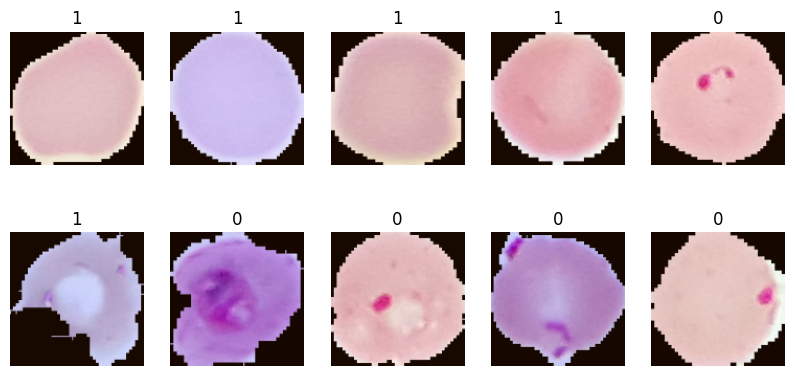

In [11]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))

    num_images = min(10, images.shape[0])

    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        img = images[i].numpy()

        if img.min() < 0 or img.max() > 1:
            img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype("uint8")
        else:
            img = (img * 255.0).astype("uint8")

        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

    plt.show()
    break

In [12]:
len(dataset)

862

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
def custom_augmentation(image, label):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

train_ds = train_ds.map(custom_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
len(train_ds)

689

In [17]:
len(val_ds)

86

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, Lambda, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K


# CBAM Block
def cbam_block(x, ratio=8):
    channel_avg = GlobalAveragePooling2D()(x)
    channel_max = GlobalMaxPooling2D()(x)
    channel_avg = Dense(K.int_shape(x)[-1] // ratio, activation='relu')(channel_avg)
    channel_max = Dense(K.int_shape(x)[-1] // ratio, activation='relu')(channel_max)
    channel_avg = Dense(K.int_shape(x)[-1], activation='sigmoid')(channel_avg)
    channel_max = Dense(K.int_shape(x)[-1], activation='sigmoid')(channel_max)
    channel_attention = Add()([channel_avg, channel_max])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    spatial_avg = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(x)
    spatial_max = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(x)
    spatial_attention = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_attention = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(spatial_attention)
    x = Multiply()([x, spatial_attention])

    return x


# Residual Block
def residual_block(x, filters):
    shortcut = x  
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  
    x = Activation('relu')(x)  
    return x


# ASPP Block (Atrous Spatial Pyramid Pooling)
def aspp_block(x, filters):
    # Apply convolutions with different dilation rates
    conv_1x1 = Conv2D(filters, (1, 1), dilation_rate=1, padding='same', activation='relu')(x)
    conv_3x3_1 = Conv2D(filters, (3, 3), dilation_rate=6, padding='same', activation='relu')(x)
    conv_3x3_2 = Conv2D(filters, (3, 3), dilation_rate=12, padding='same', activation='relu')(x)
    conv_3x3_3 = Conv2D(filters, (3, 3), dilation_rate=18, padding='same', activation='relu')(x)

    # Global Average Pooling
    global_avg_pool = GlobalAveragePooling2D()(x)
    global_avg_pool = Reshape((1, 1, K.int_shape(x)[-1]))(global_avg_pool)
    global_avg_pool = Conv2D(filters, (1, 1), padding='same', activation='relu')(global_avg_pool)
    global_avg_pool = UpSampling2D(size=(K.int_shape(x)[1], K.int_shape(x)[2]), interpolation='bilinear')(global_avg_pool)

    x = Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, global_avg_pool])
    return x


# CNN Branch
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = residual_block(x, 128)  
x = cbam_block(x)  
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = cbam_block(x)  
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = cbam_block(x)  
x = MaxPooling2D((2, 2))(x)

# Apply ASPP Block
x = aspp_block(x, 256)

cnn_features = Flatten()(x)  

# Pretrained CNN model
cnn_backbone = EfficientNetB0(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', weights='imagenet')
cnn_backbone.trainable = False
effcnn_features = cnn_backbone(inputs)

# Concatenation of the custom CNN and pretrained CNN Features
merged_features = Concatenate()([cnn_features, effcnn_features])

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged_features)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 128)    │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 128)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 21,201,134 (80.88 MB)

 Trainable params: 17,149,067 (65.42 MB)

 Non-trainable params: 4,052,067 (15.46 MB)

In [20]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
def lr_schedule(epoch):
    initial_lr = 1e-3
    k = 0.3 
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[LearningRateScheduler(lr_schedule)]
)

Learning rate:  0.001
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 230s 211ms/step - accuracy: 0.8909 - loss: 0.8046 - val_accuracy: 0.9568 - val_loss: 0.2362 - learning_rate: 0.0010
Learning rate:  0.0007408182206817179
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 95s 139ms/step - accuracy: 0.9402 - loss: 0.2585 - val_accuracy: 0.9484 - val_loss: 0.2056 - learning_rate: 7.4082e-04
Learning rate:  0.0005488116360940264
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.9445 - loss: 0.2046 - val_accuracy: 0.9549 - val_loss: 0.1659 - learning_rate: 5.4881e-04
Learning rate:  0.0004065696597405992
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.9499 - loss: 0.1798 - val_accuracy: 0.9571 - val_loss: 0.1576 - learning_rate: 4.0657e-04
Learning rate:  0.00030119421191220216
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.9517 - loss: 0.1631 - val_accuracy: 0.9575 - val_loss: 0.1453 - learning_rate: 3.0119e-04
Learning rate:  0.000223130160148

In [23]:
loss, accuracy = model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9659 - loss: 0.1398
Test loss: 0.14104674756526947
Test accuracy: 0.9659173488616943


87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step


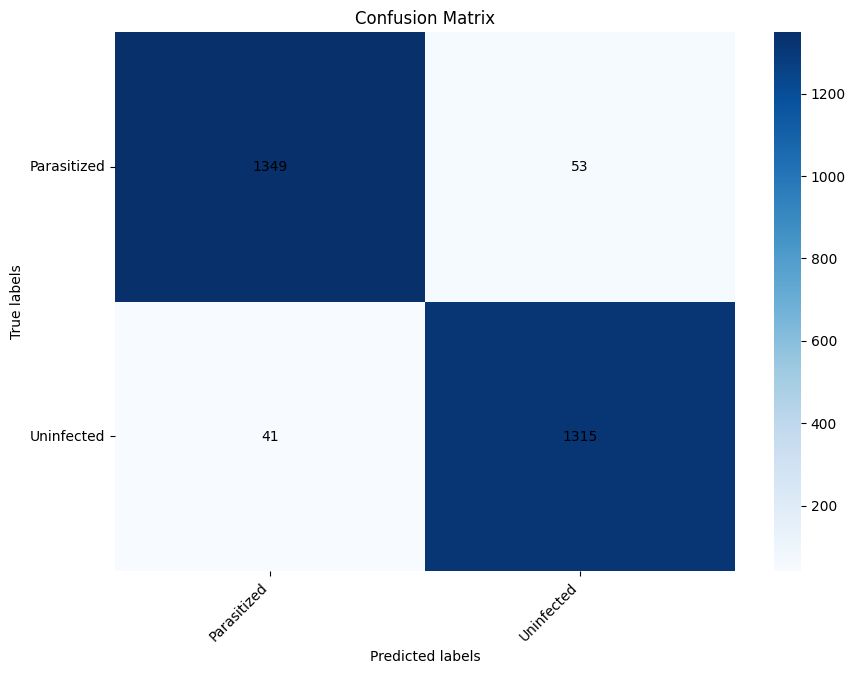

In [24]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = []
for images, labels in test_ds.unbatch(): 
    true_labels.append(labels.numpy())
true_labels = np.array(true_labels)

class_names = ['Parasitized', 'Uninfected']

plt.figure(figsize=(10, 7))
cm = confusion_matrix(true_labels, predicted_classes)
heatmap = sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names, annot=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = heatmap.text(j + 0.5, i + 0.5, cm[i, j],
                            ha="center", va="center", color="black")

plt.show()

In [25]:
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97      1402
  Uninfected       0.96      0.97      0.97      1356

    accuracy                           0.97      2758
   macro avg       0.97      0.97      0.97      2758
weighted avg       0.97      0.97      0.97      2758

Test loss: 0.14104674756526947
Test accuracy: 0.9659173488616943
